## **1. Setting**

In [ ]:
# import package
%%capture
import sys

if 'google.colab' in sys.modules:
  !pip install xgboost
  !pip install optuna
  !pip install catboost
  !pip install scikit-learn-intelex

In [ ]:
# drive.mount
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# import library
import math
import optuna
import gc
import time

import pandas as pd
import numpy as np
from scipy.stats import mode
import matplotlib.pyplot as plt
from functools import partial

# reference : https://www.kaggle.com/c/tabular-playground-series-dec-2021/discussion/291823
from sklearnex import patch_sklearn
patch_sklearn()

# scaling & encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix

import xgboost
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

pd.set_option('float_format', '{:f}'.format)
SEED = 42

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## **2. Read Data & Encoding**

In [ ]:
# import data
PATH = 'dir/'

df = pd.read_csv(PATH + "train.csv")
test = pd.read_csv(PATH + "test.csv")
sub = pd.read_csv(PATH + 'submission.csv')
pseudolabels = pd.read_csv(PATH + "tps12-pseudolabels_v2.csv")

# data shape
df.shape, test.shape, sub.shape, pseudolabels.shape

((3999622, 64), (1000000, 63), (1000000, 2))

In [ ]:
# LabelEncoding
encoder = LabelEncoder()
target = 'Cover_Type'

df[target] = encoder.fit_transform(df[target])

## **3. (Option) Data Sampling**

In [ ]:
# # 데이터가 너무 많기 때문에 베이스 라인을 잡는 경우 계층 추출
# def sampling_func(data, sample_pct) :
#     np.random.seed(SEED)
#     N = len(data)
#     sample_n = int(len(data) * sample_pct)
#     sample = data.take(np.random.permutation(N)[:sample_n])
#     return sample

# df = df.groupby('Cover_Type').apply(sampling_func, sample_pct = 0.1)
# df.shape

(399960, 64)

## **4. Reduce Data Size**

In [ ]:
def reduce_mem_usage(df, verbose = True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024 ** 2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

df = reduce_mem_usage(df)
test = reduce_mem_usage(test)

Mem. usage decreased to 484.42 Mb (75.2% reduction)
Mem. usage decreased to 120.16 Mb (75.0% reduction)


In [ ]:
df = pd.concat([df, pseudolabels], axis=0)

## **5. Data Split**

In [ ]:
features_list = df.drop(columns = [target]).columns

train, val = train_test_split(df,
                              train_size = 0.80,
                              test_size = 0.20, 
                              stratify = df[target],
                              random_state = SEED)

X_train = train[features_list]
y_train = train[target]
X_val = val[features_list]
y_val = val[target]
X_test = test[features_list]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape

((3199697, 63), (3199697,), (799925, 63), (799925,), (1000000, 63))

## **6. Modeling (OPTUNA)**

In [ ]:
# reference : https://www.kaggle.com/satoshiss/tps-december-xgbclassifier
# XGBClassifier Setting
def objective(trial,
              X,
              y,
              name = 'xgb'):
  
    # 'predictor': 'gpu_predictor',
    # 'sampling_method': 'gradient_based',
    # 'grow_policy': 'lossguide',
    # 'max_leaves': 255,

    # Parameter Setting
    params = param = {
        'objective': 'multi:softprob',
        'tree_method': 'gpu_hist',  
        'lambda': trial.suggest_loguniform(
            'lambda', 1e-3, 10.0
        ),
        'alpha': trial.suggest_loguniform(
            'alpha', 1e-3, 10.0
        ),
        'colsample_bytree': trial.suggest_categorical(
            'colsample_bytree', [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        ),
        'subsample': trial.suggest_categorical(
            'subsample', [0.6, 0.7, 0.8, 1.0]
        ),
        'learning_rate': trial.suggest_categorical(
            'learning_rate', [0.01, 0.09, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4]
        ),
        'n_estimators': trial.suggest_categorical(
            "n_estimators", [150, 200, 300]
        ),
        'max_depth': trial.suggest_categorical(
            'max_depth', [4, 5, 7, 9, 11, 13, 15, 17]
        ),
        'random_state': SEED,
        'min_child_weight': trial.suggest_int(
            'min_child_weight', 1, 300
        )}

    # Model Setting
    model = XGBClassifier(**params)
    model.fit(X_train,
              y_train,
              eval_set = [(X_val, y_val)], 
              early_stopping_rounds = 50,
              verbose = False)

    # Calculating Score
    train_score = np.round(accuracy_score(y_train, model.predict(X_train)), 5)
    test_score = np.round(accuracy_score(y_val, model.predict(X_val)), 5)
                  
    print(f'TRAIN ROC : {train_score} || TEST ROC : {test_score}')
                  
    return test_score

In [ ]:
# Optuna Setting
optimize = partial(objective,
                   X = X_train,
                   y = y_train)

study = optuna.create_study(direction = 'maximize')

study.optimize(optimize,
               n_trials = 30)

print(f"\tBest value (roc): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
  print(f"\t\t{key}: {value}")

[I 2022-01-09 06:02:25,915] A new study created in memory with name: no-name-df601f3b-bb18-4bf0-afef-406820cc10aa
[I 2022-01-09 06:07:12,399] Trial 0 finished with value: 0.93089 and parameters: {'lambda': 0.329881925237292, 'alpha': 0.10574693827331452, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.01, 'n_estimators': 300, 'max_depth': 5, 'min_child_weight': 235}. Best is trial 0 with value: 0.93089.


TRAIN ROC : 0.93132 || TEST ROC : 0.93089


[I 2022-01-09 06:11:19,724] Trial 1 finished with value: 0.9618 and parameters: {'lambda': 0.158914861533584, 'alpha': 0.06428561132056304, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.1, 'n_estimators': 200, 'max_depth': 11, 'min_child_weight': 105}. Best is trial 1 with value: 0.9618.


TRAIN ROC : 0.96588 || TEST ROC : 0.9618


[I 2022-01-09 06:15:00,741] Trial 2 finished with value: 0.96032 and parameters: {'lambda': 0.0033149205778114123, 'alpha': 3.6557627123574767, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.09, 'n_estimators': 200, 'max_depth': 7, 'min_child_weight': 64}. Best is trial 1 with value: 0.9618.


TRAIN ROC : 0.96194 || TEST ROC : 0.96032


[I 2022-01-09 06:19:17,854] Trial 3 finished with value: 0.95721 and parameters: {'lambda': 1.6149091624236478, 'alpha': 7.167508123134493, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.09, 'n_estimators': 300, 'max_depth': 4, 'min_child_weight': 153}. Best is trial 1 with value: 0.9618.


TRAIN ROC : 0.95791 || TEST ROC : 0.95721


[I 2022-01-09 06:22:10,840] Trial 4 finished with value: 0.95436 and parameters: {'lambda': 4.1275572403392555, 'alpha': 0.004327692048487594, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.09, 'n_estimators': 200, 'max_depth': 4, 'min_child_weight': 272}. Best is trial 1 with value: 0.9618.


TRAIN ROC : 0.95496 || TEST ROC : 0.95436


[I 2022-01-09 06:24:46,890] Trial 5 finished with value: 0.96184 and parameters: {'lambda': 3.5195173044661243, 'alpha': 0.9231100524391517, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.3, 'n_estimators': 150, 'max_depth': 17, 'min_child_weight': 89}. Best is trial 5 with value: 0.96184.


TRAIN ROC : 0.97157 || TEST ROC : 0.96184


[I 2022-01-09 06:30:05,782] Trial 6 finished with value: 0.94736 and parameters: {'lambda': 0.1062289550820126, 'alpha': 0.15871226280173398, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.01, 'n_estimators': 300, 'max_depth': 7, 'min_child_weight': 204}. Best is trial 5 with value: 0.96184.


TRAIN ROC : 0.94785 || TEST ROC : 0.94736


[I 2022-01-09 06:33:21,232] Trial 7 finished with value: 0.9619 and parameters: {'lambda': 0.01751995570101026, 'alpha': 0.23756339621802966, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.25, 'n_estimators': 150, 'max_depth': 13, 'min_child_weight': 57}. Best is trial 7 with value: 0.9619.


TRAIN ROC : 0.9734 || TEST ROC : 0.9619


[I 2022-01-09 06:37:38,986] Trial 8 finished with value: 0.96171 and parameters: {'lambda': 0.006517047028708747, 'alpha': 0.9531508632873034, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.09, 'n_estimators': 200, 'max_depth': 13, 'min_child_weight': 271}. Best is trial 7 with value: 0.9619.


TRAIN ROC : 0.96448 || TEST ROC : 0.96171


[I 2022-01-09 06:39:59,518] Trial 9 finished with value: 0.96068 and parameters: {'lambda': 0.11828205609749778, 'alpha': 0.6509026395393255, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.25, 'n_estimators': 150, 'max_depth': 5, 'min_child_weight': 50}. Best is trial 7 with value: 0.9619.


TRAIN ROC : 0.96188 || TEST ROC : 0.96068


[I 2022-01-09 06:43:00,376] Trial 10 finished with value: 0.96127 and parameters: {'lambda': 0.01660041978445304, 'alpha': 0.006896959654176067, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.2, 'n_estimators': 150, 'max_depth': 15, 'min_child_weight': 2}. Best is trial 7 with value: 0.9619.


TRAIN ROC : 0.98767 || TEST ROC : 0.96127


[I 2022-01-09 06:45:33,135] Trial 11 finished with value: 0.9618 and parameters: {'lambda': 0.017071566845831422, 'alpha': 0.6404794760438773, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.3, 'n_estimators': 150, 'max_depth': 17, 'min_child_weight': 122}. Best is trial 7 with value: 0.9619.


TRAIN ROC : 0.96953 || TEST ROC : 0.9618


[I 2022-01-09 06:48:24,758] Trial 12 finished with value: 0.96188 and parameters: {'lambda': 8.600609161885359, 'alpha': 0.021957287943141297, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.35, 'n_estimators': 150, 'max_depth': 9, 'min_child_weight': 58}. Best is trial 7 with value: 0.9619.


TRAIN ROC : 0.96785 || TEST ROC : 0.96188


[I 2022-01-09 06:51:21,389] Trial 13 finished with value: 0.96197 and parameters: {'lambda': 0.0012251632621941067, 'alpha': 0.016583724427224424, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.35, 'n_estimators': 150, 'max_depth': 9, 'min_child_weight': 3}. Best is trial 13 with value: 0.96197.


TRAIN ROC : 0.97385 || TEST ROC : 0.96197


[I 2022-01-09 06:54:10,518] Trial 14 finished with value: 0.96119 and parameters: {'lambda': 0.0010406700239065677, 'alpha': 0.0011318734170871188, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.35, 'n_estimators': 150, 'max_depth': 13, 'min_child_weight': 1}. Best is trial 13 with value: 0.96197.


TRAIN ROC : 0.98504 || TEST ROC : 0.96119


[I 2022-01-09 06:57:03,046] Trial 15 finished with value: 0.962 and parameters: {'lambda': 0.0010090774096955084, 'alpha': 0.02677834091501424, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.25, 'n_estimators': 150, 'max_depth': 9, 'min_child_weight': 36}. Best is trial 15 with value: 0.962.


TRAIN ROC : 0.96887 || TEST ROC : 0.962


[I 2022-01-09 06:59:59,384] Trial 16 finished with value: 0.96206 and parameters: {'lambda': 0.0011706144124413523, 'alpha': 0.022714814964491428, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.4, 'n_estimators': 150, 'max_depth': 9, 'min_child_weight': 29}. Best is trial 16 with value: 0.96206.


TRAIN ROC : 0.97061 || TEST ROC : 0.96206


[I 2022-01-09 07:02:51,133] Trial 17 finished with value: 0.96189 and parameters: {'lambda': 0.004386851790884262, 'alpha': 0.027425276985435905, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.4, 'n_estimators': 150, 'max_depth': 9, 'min_child_weight': 160}. Best is trial 16 with value: 0.96206.


TRAIN ROC : 0.96738 || TEST ROC : 0.96189


[I 2022-01-09 07:05:26,711] Trial 18 finished with value: 0.96182 and parameters: {'lambda': 0.0021158759711069337, 'alpha': 0.003197794150042714, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.4, 'n_estimators': 150, 'max_depth': 9, 'min_child_weight': 34}. Best is trial 16 with value: 0.96206.


TRAIN ROC : 0.96702 || TEST ROC : 0.96182


[I 2022-01-09 07:08:26,343] Trial 19 finished with value: 0.96177 and parameters: {'lambda': 0.03832418182422043, 'alpha': 0.041846115802932446, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.4, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 186}. Best is trial 16 with value: 0.96206.


TRAIN ROC : 0.96608 || TEST ROC : 0.96177


[I 2022-01-09 07:12:01,060] Trial 20 finished with value: 0.96179 and parameters: {'lambda': 0.5518766295930821, 'alpha': 0.007376607265124316, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.25, 'n_estimators': 150, 'max_depth': 15, 'min_child_weight': 116}. Best is trial 16 with value: 0.96206.


TRAIN ROC : 0.97107 || TEST ROC : 0.96179


[I 2022-01-09 07:14:58,003] Trial 21 finished with value: 0.96202 and parameters: {'lambda': 0.001125561173170624, 'alpha': 0.015043405143563924, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.35, 'n_estimators': 150, 'max_depth': 9, 'min_child_weight': 21}. Best is trial 16 with value: 0.96206.


TRAIN ROC : 0.97013 || TEST ROC : 0.96202


[I 2022-01-09 07:18:01,999] Trial 22 finished with value: 0.96164 and parameters: {'lambda': 0.002109351035382978, 'alpha': 0.014513835059327336, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.1, 'n_estimators': 150, 'max_depth': 9, 'min_child_weight': 26}. Best is trial 16 with value: 0.96206.


TRAIN ROC : 0.96536 || TEST ROC : 0.96164


[I 2022-01-09 07:20:58,153] Trial 23 finished with value: 0.96207 and parameters: {'lambda': 0.005856909748139575, 'alpha': 0.0645620609229157, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.2, 'n_estimators': 150, 'max_depth': 9, 'min_child_weight': 85}. Best is trial 23 with value: 0.96207.


TRAIN ROC : 0.96635 || TEST ROC : 0.96207


[I 2022-01-09 07:23:46,127] Trial 24 finished with value: 0.962 and parameters: {'lambda': 0.007980527542574807, 'alpha': 0.2769556603835288, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.2, 'n_estimators': 150, 'max_depth': 11, 'min_child_weight': 90}. Best is trial 23 with value: 0.96207.


TRAIN ROC : 0.96635 || TEST ROC : 0.962


[I 2022-01-09 07:26:42,395] Trial 25 finished with value: 0.96201 and parameters: {'lambda': 0.037617784218305, 'alpha': 0.06412174928700859, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.2, 'n_estimators': 150, 'max_depth': 9, 'min_child_weight': 80}. Best is trial 23 with value: 0.96207.


TRAIN ROC : 0.9665 || TEST ROC : 0.96201


[I 2022-01-09 07:29:32,099] Trial 26 finished with value: 0.96183 and parameters: {'lambda': 0.0025242116801945597, 'alpha': 0.0017927683919457913, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.35, 'n_estimators': 150, 'max_depth': 9, 'min_child_weight': 27}. Best is trial 23 with value: 0.96207.


TRAIN ROC : 0.96752 || TEST ROC : 0.96183


[I 2022-01-09 07:32:29,815] Trial 27 finished with value: 0.96196 and parameters: {'lambda': 0.007956391028232299, 'alpha': 0.010674718033765653, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.2, 'n_estimators': 150, 'max_depth': 9, 'min_child_weight': 77}. Best is trial 23 with value: 0.96207.


TRAIN ROC : 0.96572 || TEST ROC : 0.96196


[I 2022-01-09 07:36:03,802] Trial 28 finished with value: 0.96183 and parameters: {'lambda': 0.00416294345048274, 'alpha': 0.04432584656773008, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.4, 'n_estimators': 200, 'max_depth': 9, 'min_child_weight': 138}. Best is trial 23 with value: 0.96207.


TRAIN ROC : 0.96691 || TEST ROC : 0.96183


[I 2022-01-09 07:40:48,433] Trial 29 finished with value: 0.93085 and parameters: {'lambda': 0.04647698641663422, 'alpha': 0.10826800709583115, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.01, 'n_estimators': 300, 'max_depth': 5, 'min_child_weight': 25}. Best is trial 23 with value: 0.96207.


TRAIN ROC : 0.93135 || TEST ROC : 0.93085
	Best value (roc): 0.96207
	Best params:
		lambda: 0.005856909748139575
		alpha: 0.0645620609229157
		colsample_bytree: 0.6
		subsample: 1.0
		learning_rate: 0.2
		n_estimators: 150
		max_depth: 9
		min_child_weight: 85


## **7. Visualization-Hyperparameter Importances**

In [ ]:
# reference : https://optuna.readthedocs.io/en/stable/reference/visualization/index.html
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [ ]:
fig = optuna.visualization.plot_slice(study, params=["learning_rate", "max_depth"])
fig.show()

## **8. Visualization-Feature Importances**

In [ ]:
# best parameter (ver. sampling data)
params = {
      'lambda': 0.005856909748139575,
      'alpha': 0.0645620609229157,
      'colsample_bytree': 0.6,
      'subsample': 1.0,
      'learning_rate': 0.2,
      'n_estimators': 150,
      'max_depth': 9,
      'min_child_weight': 85
      }

In [ ]:
model = XGBClassifier(**params,
                      objective = 'multi:softprob',
                      tree_method = 'gpu_hist',
                      booster='gbtree',
                      importance_type='gain')

model.fit(X_train, y_train,
          eval_set = [(X_val, y_val)],
          early_stopping_rounds = 50,
          verbose = False)

array([0.22489603, 0.00182205, 0.00744368, 0.01243842, 0.00911173,
       0.0234781 , 0.0190577 , 0.00634812, 0.00288933, 0.00935021,
       0.00541412, 0.00040398, 0.00043758, 0.00051839, 0.        ,
       0.        , 0.00051833, 0.00239268, 0.00073235, 0.00115018,
       0.00082092, 0.04832659, 0.01791229, 0.04698125, 0.1373263 ,
       0.01236049, 0.02670581, 0.02751162, 0.01790903, 0.01147231,
       0.02332082, 0.00142522, 0.00280233, 0.02026137, 0.01034239,
       0.0035374 , 0.01090321, 0.00227188, 0.00148738, 0.01204376,
       0.00212165, 0.00213436, 0.00328151, 0.00182709, 0.01814437,
       0.01269167, 0.00700097, 0.00107509, 0.00273892, 0.00178895,
       0.0015117 , 0.00461949, 0.00344297, 0.00903932, 0.01020753,
       0.01519266, 0.00346028, 0.018773  , 0.01504287, 0.01886702,
       0.02611427, 0.03308202, 0.02371688], dtype=float32)

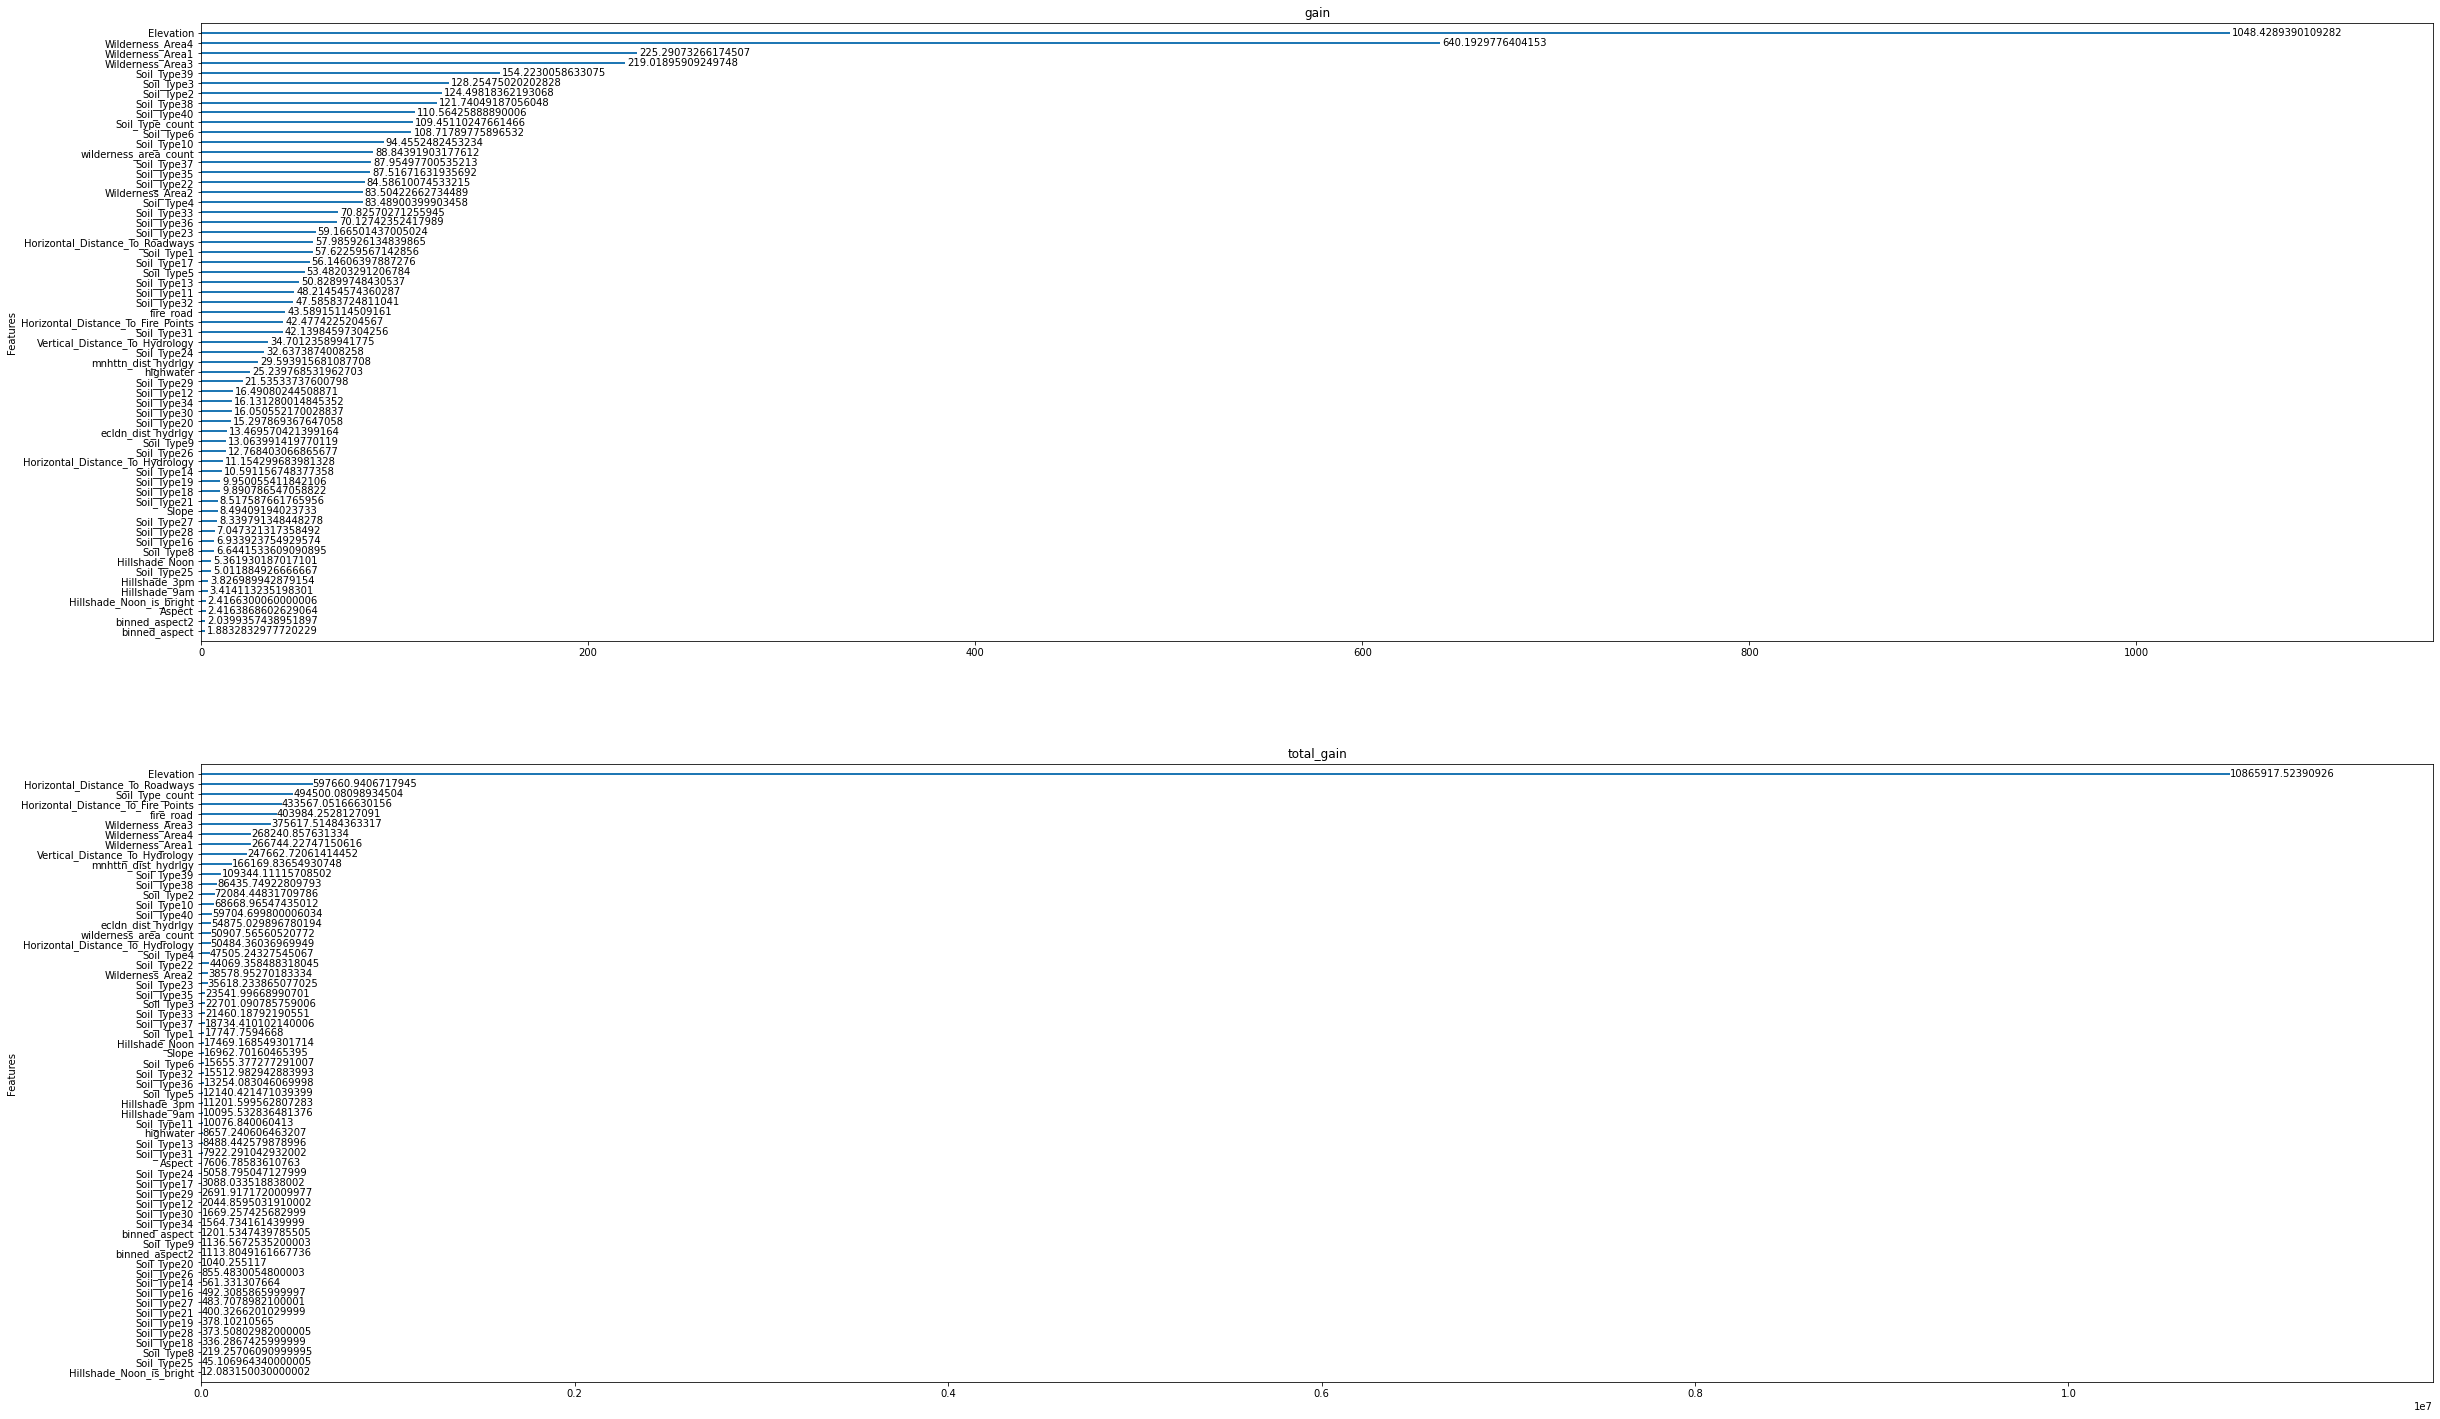

In [ ]:
# reference: https://hongl.tistory.com/131
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(40,25))

xgboost.plot_importance(model, importance_type='gain', title='gain', xlabel='', grid=False, ax=axes[0])
xgboost.plot_importance(model, importance_type='total_gain', title='total_gain', xlabel='', grid=False, ax=axes[1])
plt.show()

In [ ]:
cm = confusion_matrix(y_val, model.predict(X_val))
ix = np.arange(cm.shape[0])
cm[ix, ix] = 0
col_names = [f'Cover_Type={cls}' for cls in encoder.classes_]
cm = pd.DataFrame(cm, columns=col_names, index=col_names)
cm

,Cover_Type=1,Cover_Type=2,Cover_Type=3,Cover_Type=6,Cover_Type=7
Cover_Type=1,0,8054,0,0,1974
Cover_Type=2,8555,0,3721,171,52
Cover_Type=3,1,3662,0,390,0
Cover_Type=6,0,281,728,0,0
Cover_Type=7,2817,62,0,0,0


In [ ]:
# best parameter
params = {
      'lambda': 1.4483993078186477,
      'alpha': 0.019604567278950057,
      'colsample_bytree': 0.9,
      'subsample': 1.0,
      'learning_rate': 0.1,
      'n_estimators': 3000,
      'max_depth': 17,
      'min_child_weight': 46
      }

# the mean Accuracy : 96.209 

## **9. Modeling (K-Fold Cross Validation)**

In [ ]:
target = 'Cover_Type'
features = df_sca_final.drop(columns = [target])
targets = df_sca_final[target]

# K-Fold cross validation
preds = []
kf = StratifiedKFold(n_splits = 20,
                     random_state = SEED,
                     shuffle = True)

acc =[]
n = 0 

for trn_idx, test_idx in kf.split(features, targets):
    X_tr, X_val = features.iloc[trn_idx], features.iloc[test_idx]
    y_tr, y_val = targets.iloc[trn_idx], targets.iloc[test_idx]
    
    model = XGBClassifier(**params,
                          objective = 'multi:softprob',
                          tree_method = 'gpu_hist')
    
    model.fit(X_tr, y_tr,
              eval_set = [(X_val, y_val)],
              early_stopping_rounds = 50,
              verbose = False)

    preds.append(model.predict(test_sca_final))
    acc.append(accuracy_score(y_val, model.predict(X_val)))
    
    print(f"fold: {n + 1} , accuracy: {round(acc[n] * 100, 6)}")
    n += 1
    
    del X_tr, X_val, y_tr, y_val

print(f"the mean Accuracy is : {round(np.mean(acc) * 100, 6)}")

fold: 1 , accuracy: 95.969597
fold: 2 , accuracy: 96.119612
fold: 3 , accuracy: 96.209621
fold: 4 , accuracy: 95.949595
fold: 5 , accuracy: 96.144614
fold: 6 , accuracy: 95.834583
fold: 7 , accuracy: 96.184618
fold: 8 , accuracy: 96.169617
fold: 9 , accuracy: 96.014601
fold: 10 , accuracy: 96.109611
fold: 11 , accuracy: 95.889589
fold: 12 , accuracy: 96.074607
fold: 13 , accuracy: 96.044604
fold: 14 , accuracy: 95.834583
fold: 15 , accuracy: 96.134613
fold: 16 , accuracy: 96.064606
fold: 17 , accuracy: 95.919592
fold: 18 , accuracy: 95.889589
fold: 19 , accuracy: 96.074607
fold: 20 , accuracy: 96.239624
the mean Accuracy is : 96.043604


## **10. Export Data**

In [ ]:
# predict & inverse transformation
prediction = stats.mode(preds)[0][0]
predictions = encoder.inverse_transform(prediction)

# submission
sub['Cover_Type'] = predictions
dataframe = pd.DataFrame(sub)
dataframe.to_csv("dir/result.csv", header = True, index = False)

## **11. (Option) for Stacking or Blending**

In [ ]:
target = 'Cover_Type'
features = df.drop(columns = [target])
targets = df[target]

features.shape, targets.shape

In [ ]:
kf = StratifiedKFold(n_splits = 20,
                     random_state = SEED,
                     shuffle = True)

TREE_EARLY_STOPPING = 50
K_FOLD_START = 0

################## LGBM ##################
lgb_params = {
    'objective' : 'multiclass',
    'metric' : 'multi_logloss',
    'tree_method':'gpu_hist',  
}
lgb_pred = []
lgb_scores = []

"""
params = {
    'metric': 'binary_logloss',
    'n_estimators': 300,
    'objective': 'multi:softprob',
    'random_state': 42,
    'learning_rate': 0.01,
    'min_child_samples': 150,
    'reg_alpha': 3e-5,
    'reg_lambda': 9e-2,
    'num_leaves': 20,
    'max_depth': 16,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'subsample_freq': 2,
    'max_bin': 240,
    'n_jobs' : -1
}
"""

################## CatBoost ##################
catb_params = {
    "objective": "MultiClass",
    "task_type": "GPU",
}
catb_pred = []
catb_scores = []

"""
params = {
    'bootstrap_type': 'Poisson',
    'loss_function': 'Logloss',
    'eval_metric': 'Logloss',
    'random_seed': 42,
    'task_type': 'GPU',
    'max_depth': 8,
    'learning_rate': 0.01,
    'n_estimators': 42,
    'max_bin': 280,
    'min_data_in_leaf': 64,
    'l2_leaf_reg': 0.01,
    'subsample': 0.8
}
# model.fit에 use_best_model = True 추가
"""

################## XGBoost ##################
xgb_params = {
    'objective': 'multi:softmax',
    'eval_metric': 'mlogloss',
    'tree_method': 'gpu_hist',
    'predictor': 'gpu_predictor',
}
xgb_pred = []
xgb_scores = []

In [ ]:
# K-Fold cross validation
for trn_idx, test_idx in kf.split(features, targets):
    start_time = time.time()
    X_tr, X_val = features.iloc[trn_idx], features.iloc[test_idx]
    y_tr, y_val = targets.iloc[trn_idx], targets.iloc[test_idx]
    
    """
    Tree Ensemble 사용시 참고

    model = LGBMClassifier(**lgb_params)
    lgb_pred.append(model.predict(test))
    lgb_scores.append(accuracy_score(y_val, model.predict(X_val)))

    model = CatBoostClassifier(**catb_params)
    catb_pred.append(model.predict(test))
    catb_scores.append(accuracy_score(y_val, model.predict(X_val)))
    
    model = XGBClassifier(**xgb_params)
    xgb_pred.append(model.predict(test))
    xgb_scores.append(accuracy_score(y_val, model.predict(X_val)))
    """

    model = LGBMClassifier(**lgb_params)
    
    model.fit(X_tr, y_tr,
              eval_set = [(X_val, y_val)],
              early_stopping_rounds = TREE_EARLY_STOPPING,
              verbose = False)

    lgb_pred.append(model.predict(test))
    lgb_scores.append(accuracy_score(y_val, model.predict(X_val)))

    run_time = time.time() - start_time
    print(f"fold: {K_FOLD_START + 1}, accuracy: {round(lgb_scores[K_FOLD_START] * 100, 6)}, Run Time: {run_time:.2f}")
    K_FOLD_START += 1
    
    del X_tr, X_val, y_tr, y_val

print(f"the mean Accuracy is : {round(np.mean(xgb_scores) * 100, 6)}")

In [ ]:
"""
결과 저장시 Naming 참고
file_name = 'lgb_sub', 'catb_sub', 'xgb_sub'
pred_name = lgb_pred, catb_pred, xgb_pred
save_name = 'lgb-subs.csv', 'catb-subs.csv', 'xgb-subs.csv'
"""

lgb_sub = sub.copy()
lgb_sub['Cover_Type'] = np.squeeze(mode(np.column_stack(lgb_pred), axis = 1)[0]).astype('int')
lgb_sub.to_csv("/content/drive/MyDrive/Colab Notebooks/lgb-subs.csv", header = True, index = False)